In [3]:
# importy 
import oracledb
import csv
import pandas as pd
from scipy.stats import describe
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
# łączenie się z bazą
# Dostęp do danych połączeniowych
db_config = {
    'user': 'MARTYNIUKP',
    'password': 'gusiu123',
    'dsn': '213.184.8.44:1521/orcl'
}
cnn = oracledb.connect(user=db_config['user'], password=db_config['password'], dsn=db_config['dsn'])

# zadanie 2

In [6]:
# zadanie 2 (trzeba zobaczyć poprawność ładowania danych do bazy punkt B i te gromadzenie punkt C)
csv_file_path = r"data\BTC-Daily.csv"
try:
    # Utworzenie kursora
    cursor = cnn.cursor()

    # Przygotowanie zapytania SQL do wstawienia danych
    insert_query = """
    INSERT INTO dane_finansowe (id, data, symbol, open, high, low, close, volume_btc, volume_usd)
    VALUES (:1, TO_TIMESTAMP(:2, 'YYYY-MM-DD HH24:MI:SS'), :3, :4, :5, :6, :7, :8, :9)
    """

    # Wczytanie danych z pliku CSV i wstawienie do tabeli
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Pominięcie nagłówka, jeśli istnieje
        for row in csv_reader:
            try:
                row = [int(row[0]), row[1], row[2], float(row[3]), float(row[4]), float(row[5]), float(row[6]), float(row[7]), float(row[8])]
                #   Przekazanie danych do bazy danych
                cursor.execute(insert_query, row)
            except:
                print("nie poprawne dane/ nie mozna wczytać do bazy")    

    # Zatwierdzenie transakcji
    cnn.commit()

finally:
    # Zamknięcie kursora i połączenia
    cursor.close()

# zadanie 3

In [7]:
# Utworzenie kursora
cursor = cnn.cursor()

# Pobranie danych z tabeli do analizy statystyki opisowej
select_data_query = "SELECT * FROM dane_finansowe"
cursor.execute(select_data_query)

# Fetch all rows from the cursor
rows = cursor.fetchall()

# Check if any data was returned
if rows:
    data = pd.DataFrame(rows, columns=['id', 'data', 'symbol', 'open', 'high', 'low', 'close', 'volume_btc', 'volume_usd'])

    # Analiza statystyki opisowej za pomocą scipy.stats.describe
    descriptive_stats = describe(data[['open', 'high', 'low', 'close', 'volume_btc', 'volume_usd']], axis=0)

    # Wyświetlenie statystyk opisowych
    print("Statystyki opisowe:")
    print(descriptive_stats)
else:
    print("No data returned from the query.")

# Zamknięcie kursora
cursor.close()

Statystyki opisowe:
DescribeResult(nobs=2651, minmax=(array([162.  , 212.84, 152.4 , 162.  ,   0.  ,   0.  ]), array([6.75474900e+04, 6.90000000e+04, 6.62500000e+04, 6.75590000e+04,
       7.72329455e+08, 1.44612547e+09])), mean=array([1.16931893e+04, 1.20385629e+04, 1.12965395e+04, 1.17093262e+04,
       1.33004138e+07, 6.09936875e+07]), variance=array([2.64796038e+08, 2.80202055e+08, 2.47064877e+08, 2.65133116e+08,
       2.22346808e+15, 1.15098146e+16]), skewness=array([1.79332548, 1.78190593, 1.8041741 , 1.78992855, 6.30774363,
       4.23497151]), kurtosis=array([ 1.99922494,  1.9400177 ,  2.057009  ,  1.98506809, 55.16558237,
       29.65902466]))


# zadanie 4

In [9]:
# Utworzenie kursora
cursor = cnn.cursor()

# Pobranie danych z tabeli do analizy
select_data_query = "SELECT open FROM dane_finansowe"
cursor.execute(select_data_query)
data = pd.DataFrame(cursor.fetchall(), columns=['open'])

# Test normalności rozkładu (Shapiro-Wilk test)
shapiro_test_stat, shapiro_p_value = stats.shapiro(data['open'])
print("Shapiro-Wilk test:")
print(f"Statystyka testowa: {shapiro_test_stat}, p-value: {shapiro_p_value}")
if shapiro_p_value > 0.05:
    print("Nie ma podstaw do odrzucenia hipotezy o normalności rozkładu.")
else:
    print("Hipoteza o normalności rozkładu zostaje odrzucona.")

# Testy dla zmiennych zależnych i niezależnych
# Przykład testu t dla zmiennych niezależnych
# Załóżmy, że mamy dwie grupy i chcemy porównać średnie wartości 'open'
group1 = data['open'].head(50)  # Pierwsza grupa
group2 = data['open'].tail(50)  # Druga grupa

# Test t dla zmiennych niezależnych
t_stat, t_p_value = stats.ttest_ind(group1, group2)
print("\nTest t dla zmiennych niezależnych:")
print(f"Statystyka testowa: {t_stat}, p-value: {t_p_value}")
if t_p_value > 0.05:
    print("Nie ma podstaw do odrzucenia hipotezy o równości średnich.")
else:
    print("Hipoteza o równości średnich zostaje odrzucona.")

# Analiza wariancji (ANOVA)
# Przykład analizy wariancji dla trzech grup
group1_anova = data['open'].head(30)
group2_anova = data['open'].iloc[30:60]
group3_anova = data['open'].tail(30)

# Przeprowadzenie analizy wariancji
anova_stat, anova_p_value = stats.f_oneway(group1_anova, group2_anova, group3_anova)
print("\nAnaliza wariancji (ANOVA):")
print(f"Statystyka testowa: {anova_stat}, p-value: {anova_p_value}")
if anova_p_value > 0.05:
    print("Nie ma podstaw do odrzucenia hipotezy o równości średnich.")
else:
    print("Hipoteza o równości średnich zostaje odrzucona.")

# Zamknięcie kursora
cursor.close()

Shapiro-Wilk test:
Statystyka testowa: 0.6906794309616089, p-value: 0.0
Hipoteza o normalności rozkładu zostaje odrzucona.

Test t dla zmiennych niezależnych:
Statystyka testowa: 36.29820323615688, p-value: 1.2447271937625122e-58
Hipoteza o równości średnich zostaje odrzucona.

Analiza wariancji (ANOVA):
Statystyka testowa: 795.8838303515736, p-value: 1.2078044582007854e-56
Hipoteza o równości średnich zostaje odrzucona.


# zadanie 5 

!!! rekordy poprawic

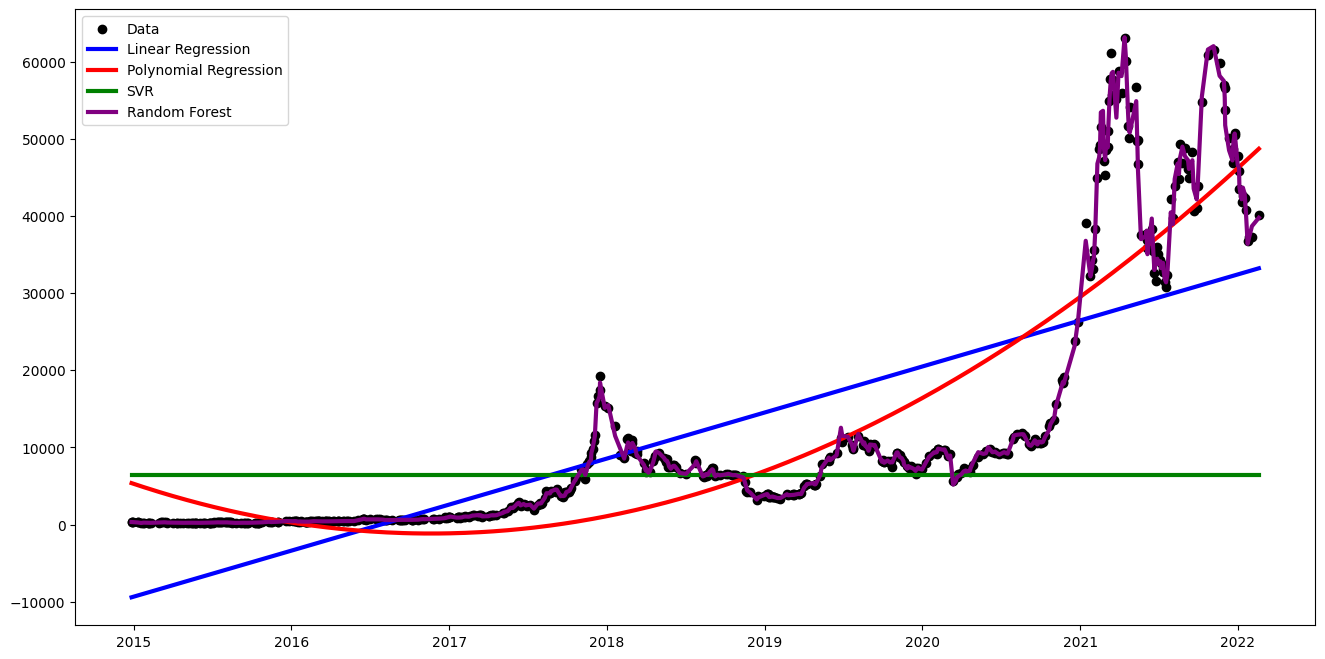

In [10]:


# Create a cursor
cursor = cnn.cursor()

# Fetch data
select_data_query = "SELECT close, data FROM dane_finansowe"
cursor.execute(select_data_query)
data = pd.DataFrame(cursor.fetchall(), columns=['close', 'data'])

# Convert date
data['date'] = pd.to_datetime(data['data'])
data.sort_values(by='date', inplace=True)
data.set_index('date', inplace=True)

# Prepare data
X = data.index.values.astype(np.int64).reshape(-1, 1) // 10**9
y = data['close'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

# Polynomial regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)
y_pred_poly = model_poly.predict(X_test_poly)

# SVR
model_svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
model_svr.fit(X_train, y_train)
y_pred_svr = model_svr.predict(X_test)

# Random Forest
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Convert timestamp back to datetime for plotting
X_test_dates = pd.to_datetime(X_test.flatten(), unit='s')

# Create a DataFrame for easier sorting
df = pd.DataFrame({
    'date': X_test_dates,
    'y_test': y_test,
    'y_pred_lr': y_pred_lr,
    'y_pred_poly': y_pred_poly,
    'y_pred_svr': y_pred_svr,
    'y_pred_rf': y_pred_rf
})

# Sort by date
df.sort_values('date', inplace=True)

# Plot
plt.figure(figsize=(16,8))
plt.scatter(df['date'], df['y_test'], color='black', label='Data')
plt.plot(df['date'], df['y_pred_lr'], color='blue', linewidth=3, label='Linear Regression')
plt.plot(df['date'], df['y_pred_poly'], color='red', linewidth=3, label='Polynomial Regression')
plt.plot(df['date'], df['y_pred_svr'], color='green', linewidth=3, label='SVR')
plt.plot(df['date'], df['y_pred_rf'], color='purple', linewidth=3, label='Random Forest')
plt.legend()
plt.show()

# Close the cursor
cursor.close()

# zadanie 7


!!! dorob wywolanie dla rocznych i kwartalnych


In [11]:
# Create a cursor
cursor = cnn.cursor()

# Iterate through years and months
for year in range(2014, 2024):
    for month in range(1, 13):
        try:
            # Call the procedure that generates the monthly summary
            cursor.callproc("generuj_podsumowanie_miesieczne", [year, month])
            print(f"Procedure successfully called for {year}-{month}")

        except oracledb.DatabaseError as e:
            error, = e.args
            print(f"Error while calling procedure for {year}-{month}: {error.message}")

    # Call the procedure that generates the quarterly summary
    for quarter in range(1, 5):
        try:
            cursor.callproc("generuj_podsumowanie_kwartalne", [year, quarter])
            print(f"Procedure successfully called for {year}-Q{quarter}")

        except oracledb.DatabaseError as e:
            error, = e.args
            print(f"Error while calling procedure for {year}-Q{quarter}: {error.message}")

    # Call the procedure that generates the yearly summary
    try:
        cursor.callproc("generuj_podsumowanie_roczne", [year])
        print(f"Procedure successfully called for {year}")

    except oracledb.DatabaseError as e:
        error, = e.args
        print(f"Error while calling procedure for {year}: {error.message}")

# Commit the transaction
cnn.commit()

# Close the cursor
cursor.close()

Procedure successfully called for 2014-1
Procedure successfully called for 2014-2
Procedure successfully called for 2014-3
Procedure successfully called for 2014-4
Procedure successfully called for 2014-5
Procedure successfully called for 2014-6
Procedure successfully called for 2014-7
Procedure successfully called for 2014-8
Procedure successfully called for 2014-9
Procedure successfully called for 2014-10
Procedure successfully called for 2014-11
Procedure successfully called for 2014-12
Procedure successfully called for 2014-Q1
Procedure successfully called for 2014-Q2
Procedure successfully called for 2014-Q3
Procedure successfully called for 2014-Q4
Procedure successfully called for 2014
Procedure successfully called for 2015-1
Procedure successfully called for 2015-2
Procedure successfully called for 2015-3
Procedure successfully called for 2015-4
Procedure successfully called for 2015-5
Procedure successfully called for 2015-6
Procedure successfully called for 2015-7
Procedure s

# zadanie 8


!!! zrobić zeby wszystkie wykresy byly w jednym obrazku 
!!! zrobić to samo dla rocznych i kwartalnych 

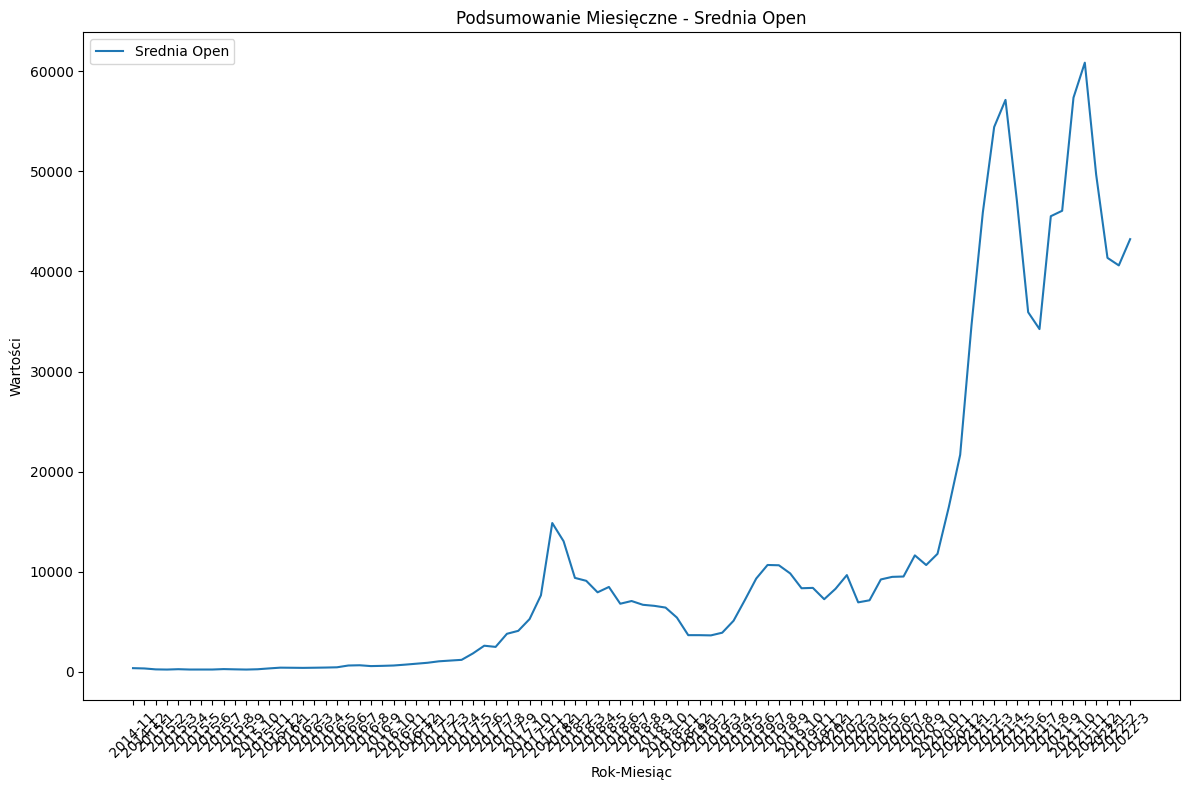

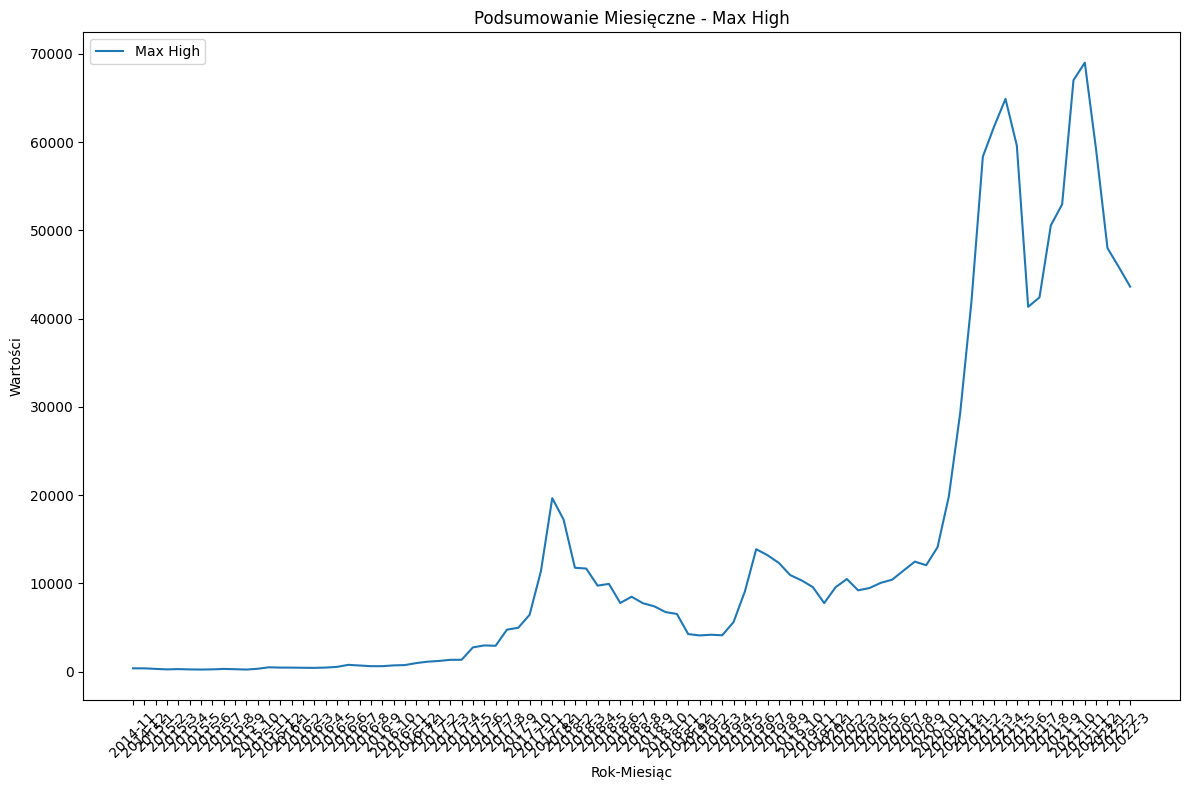

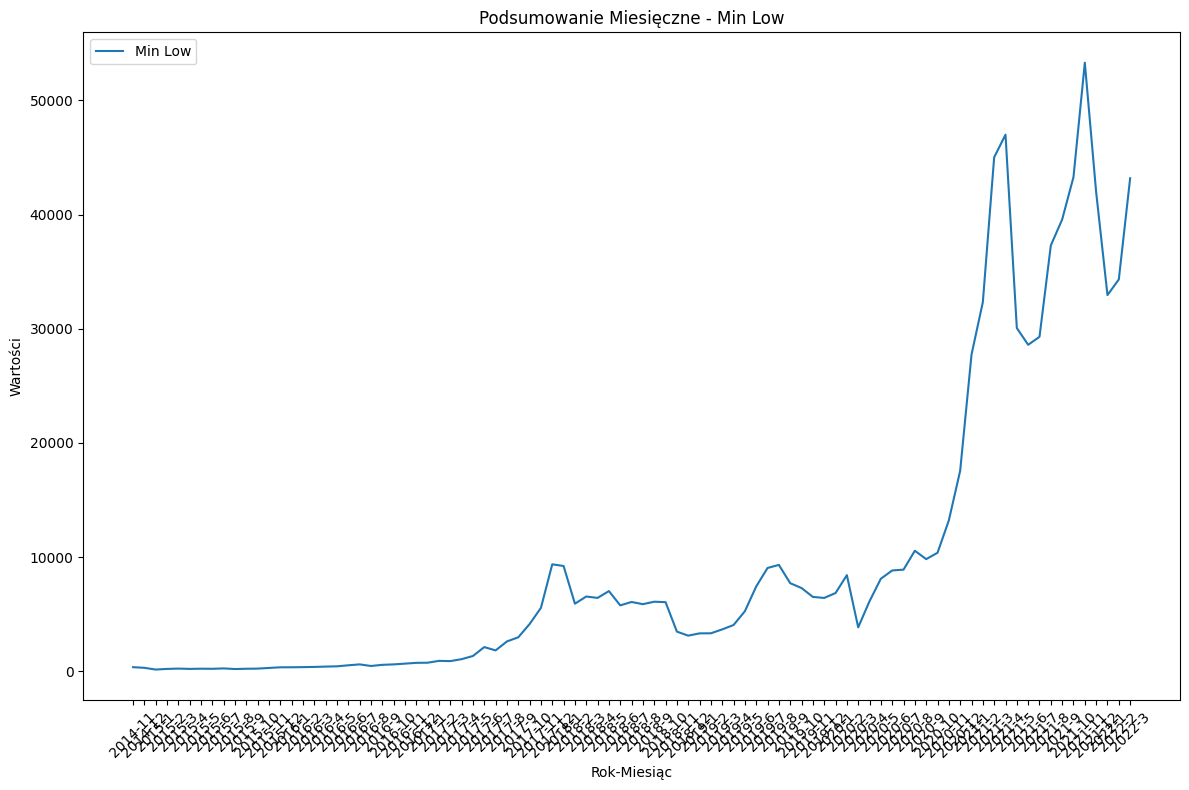

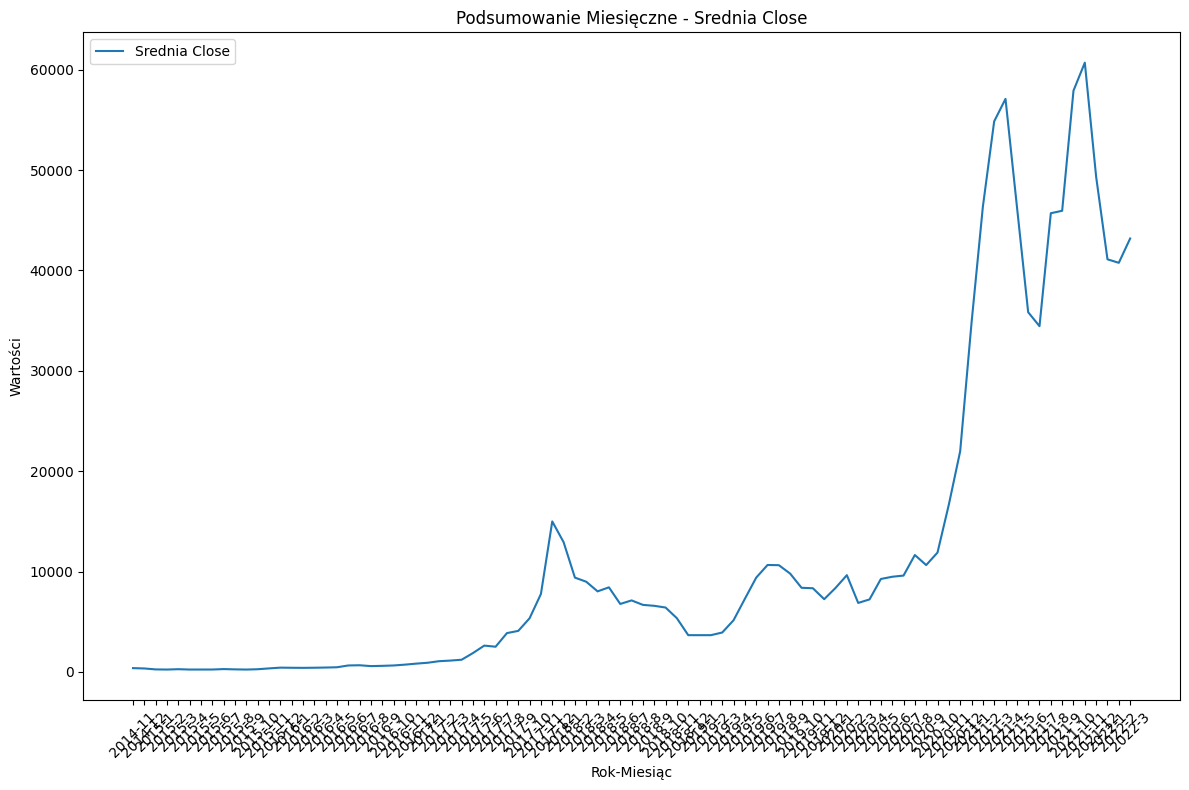

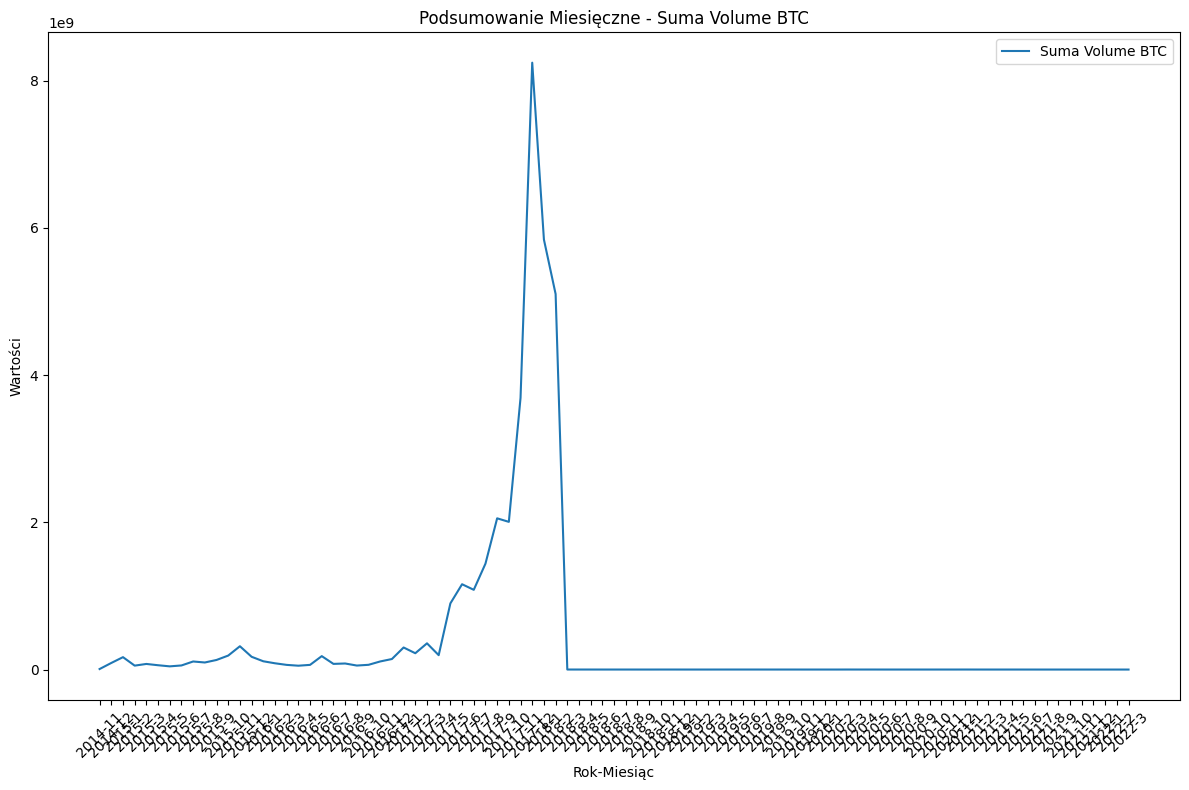

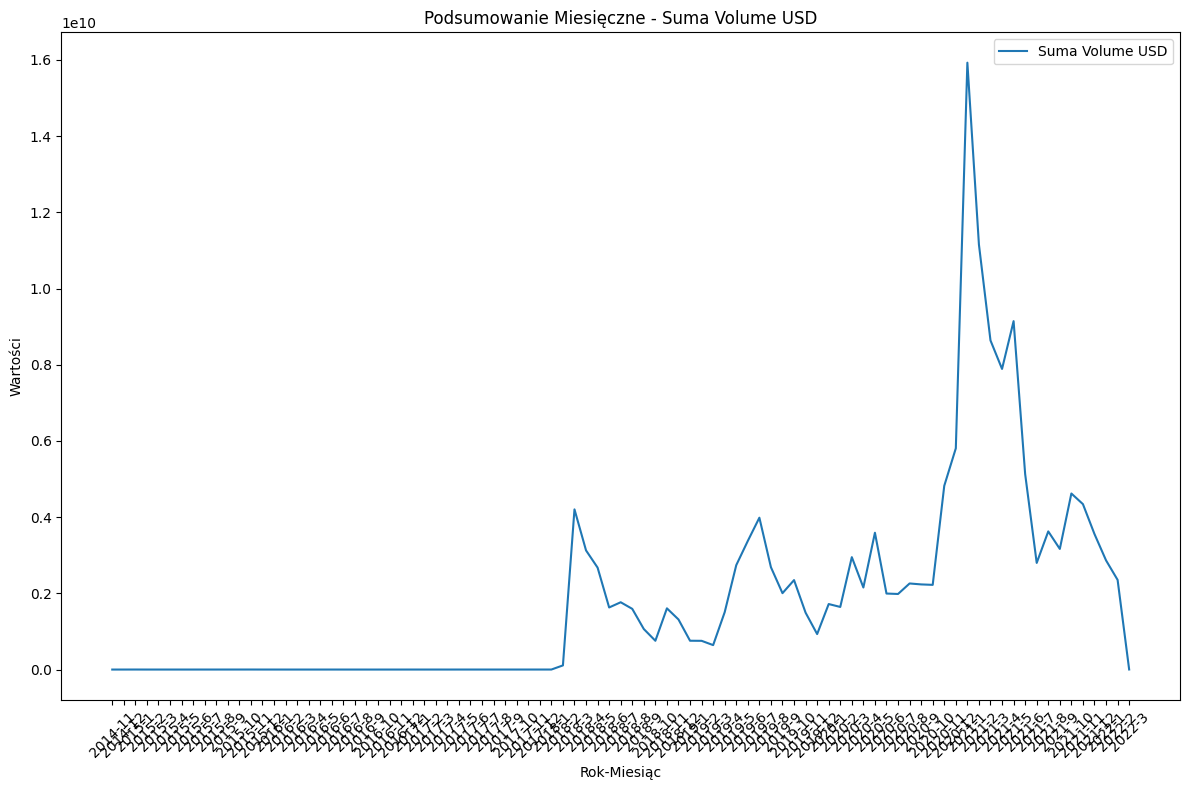

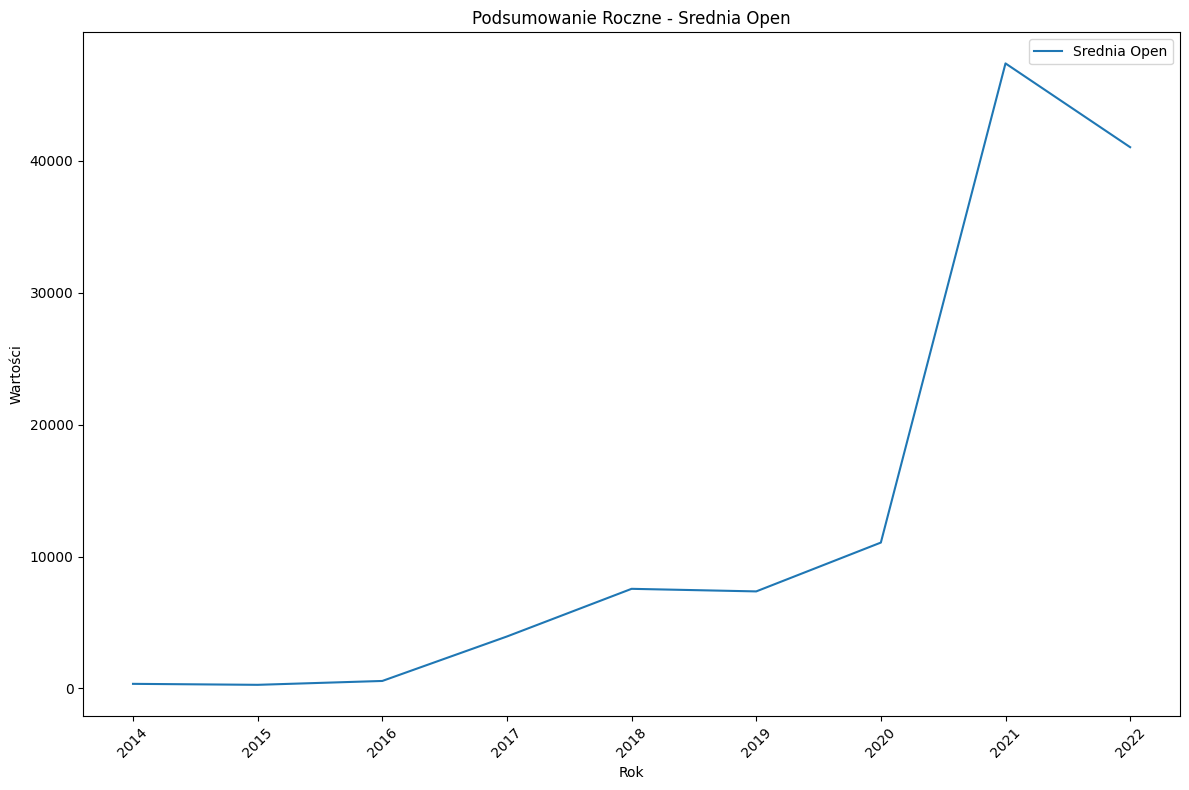

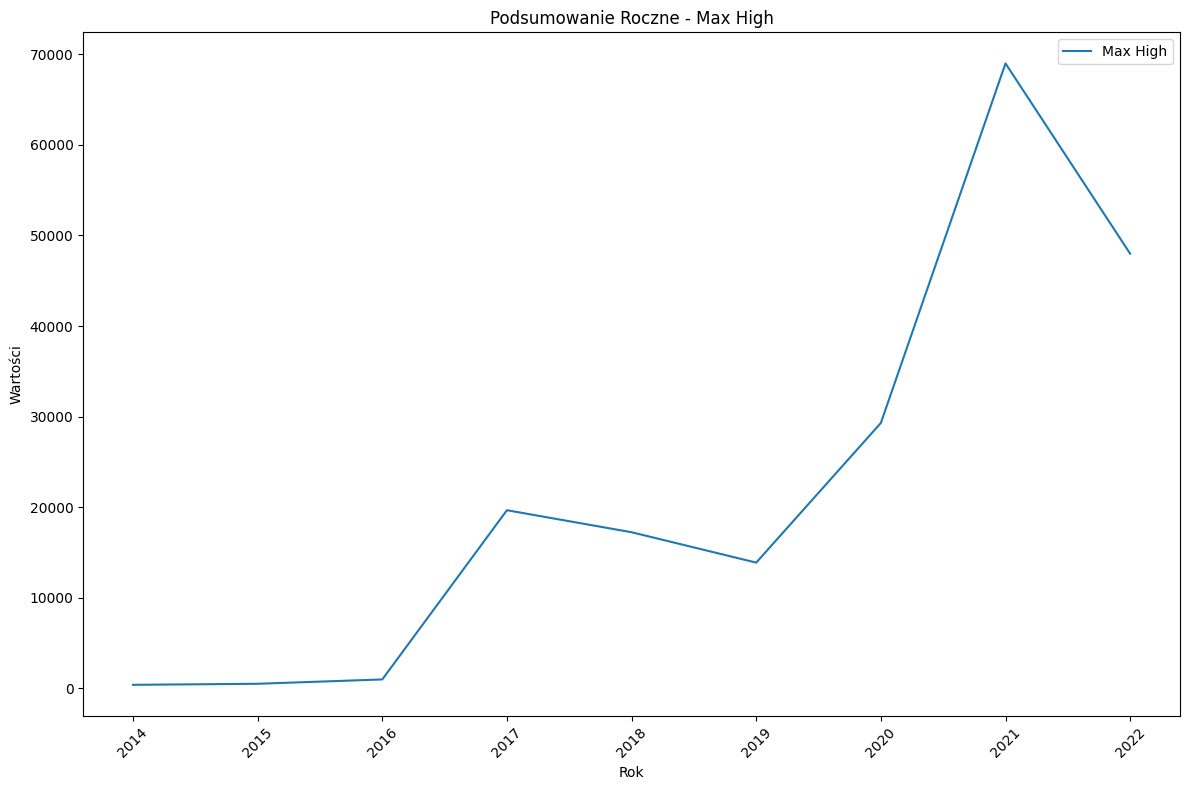

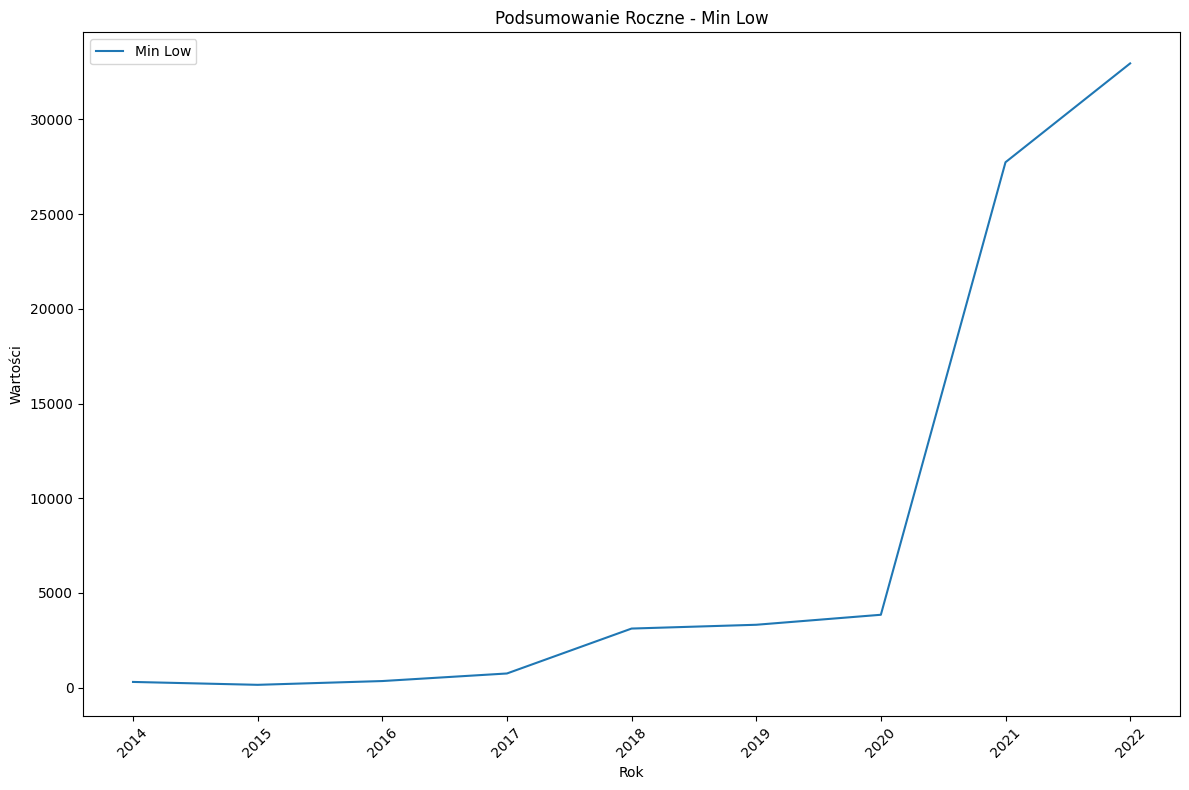

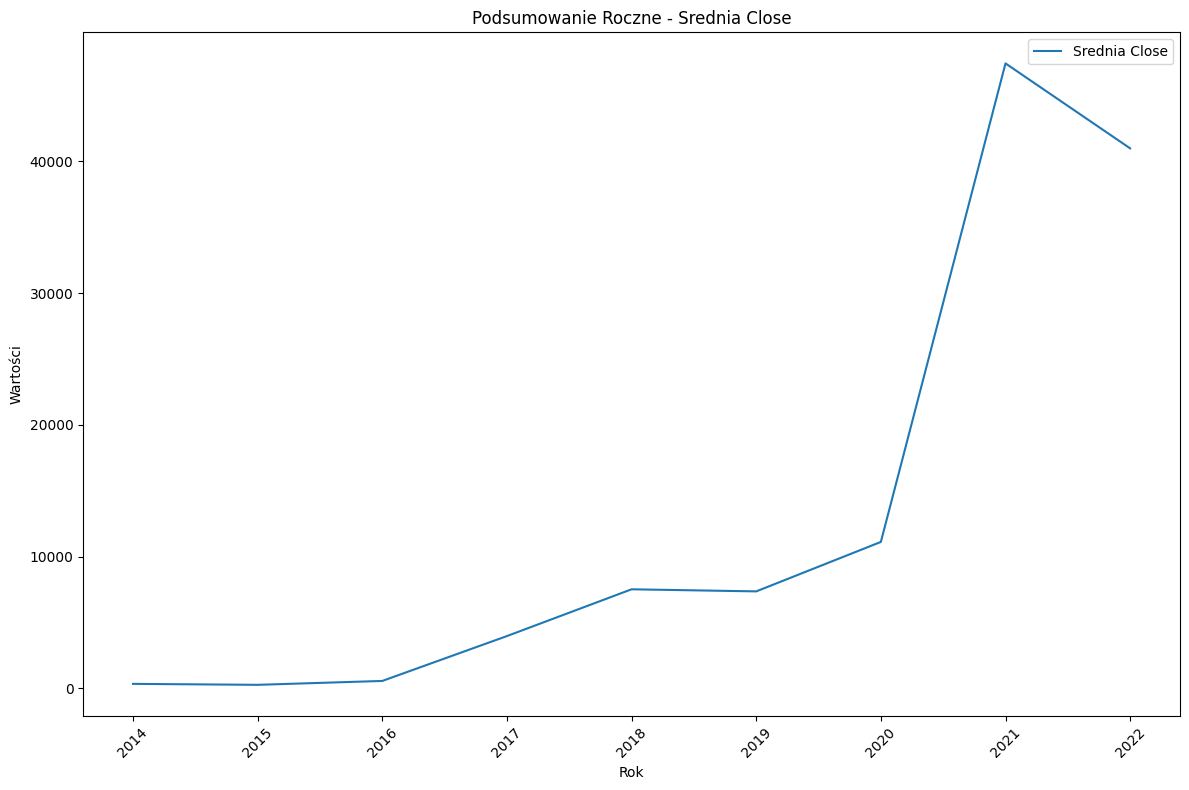

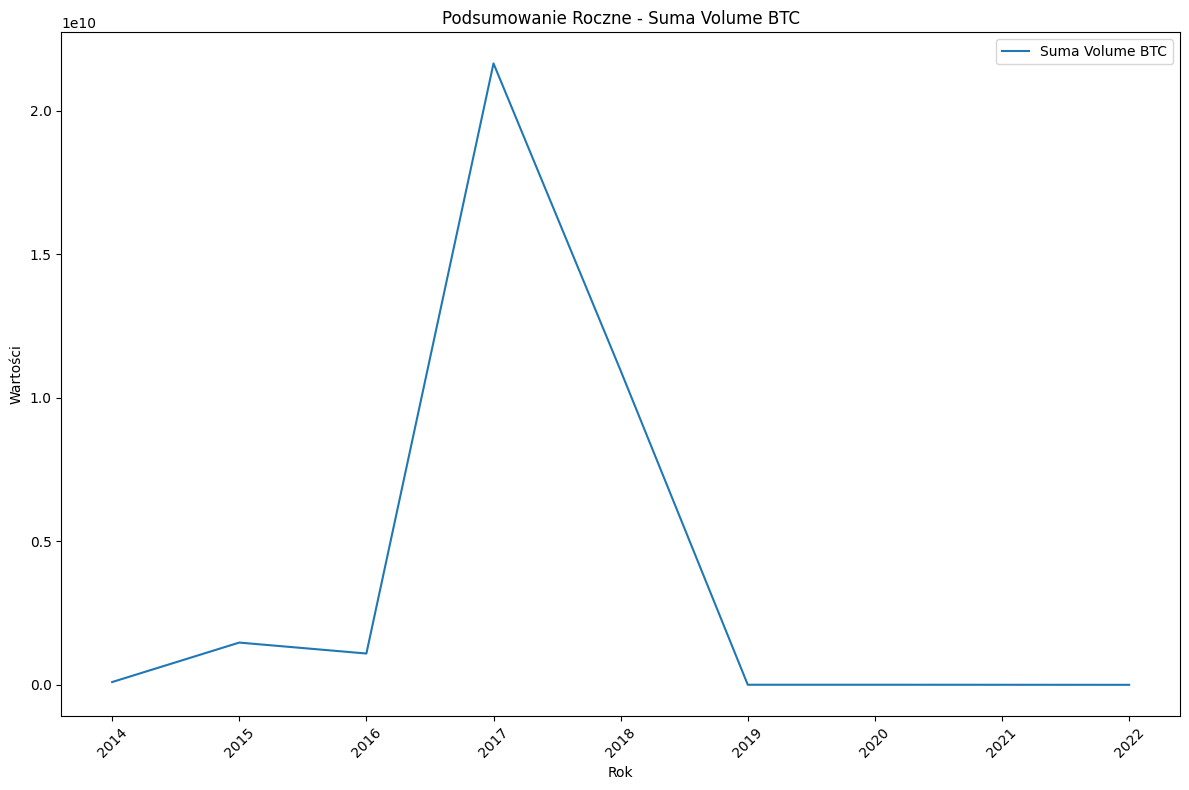

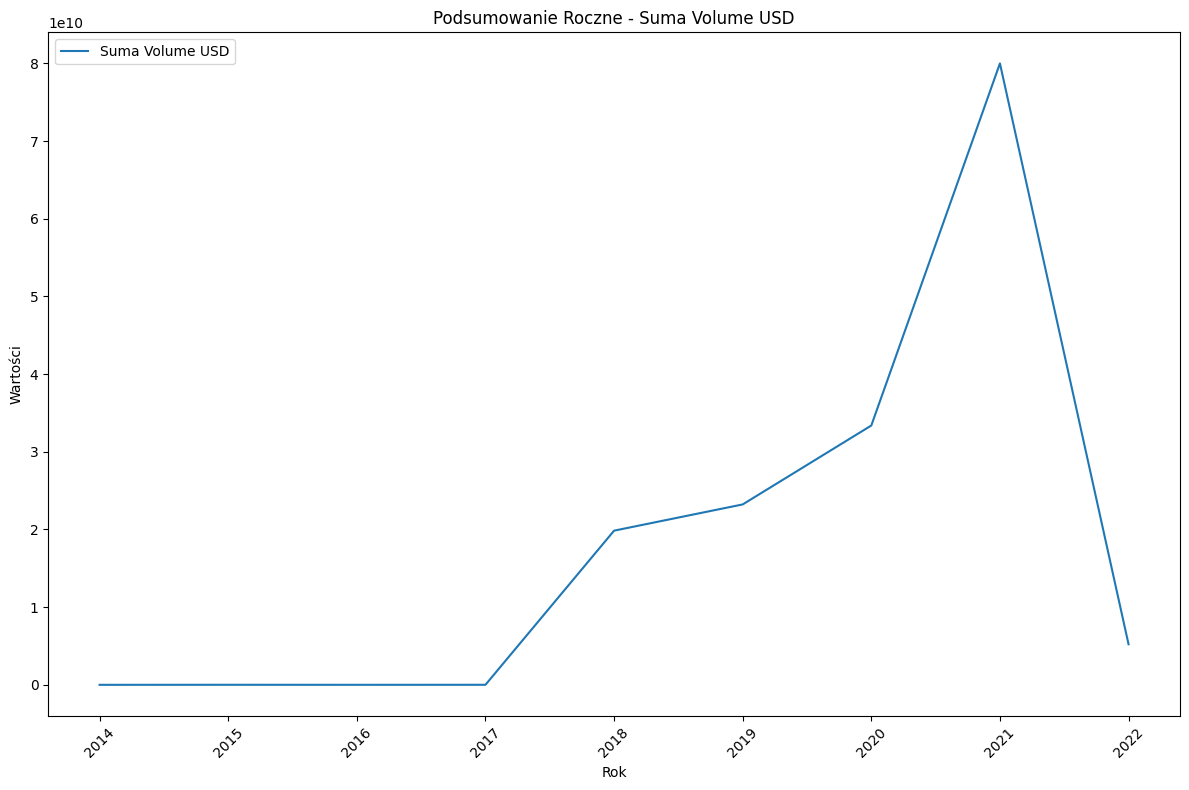

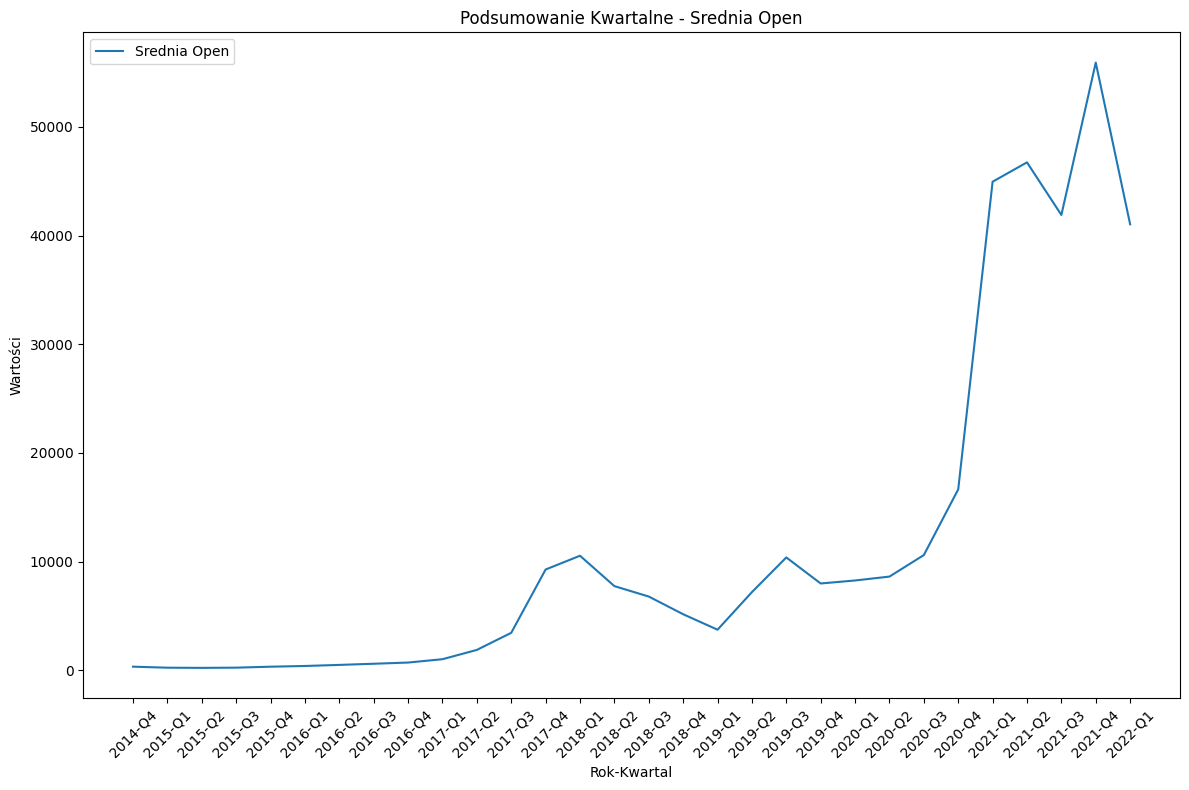

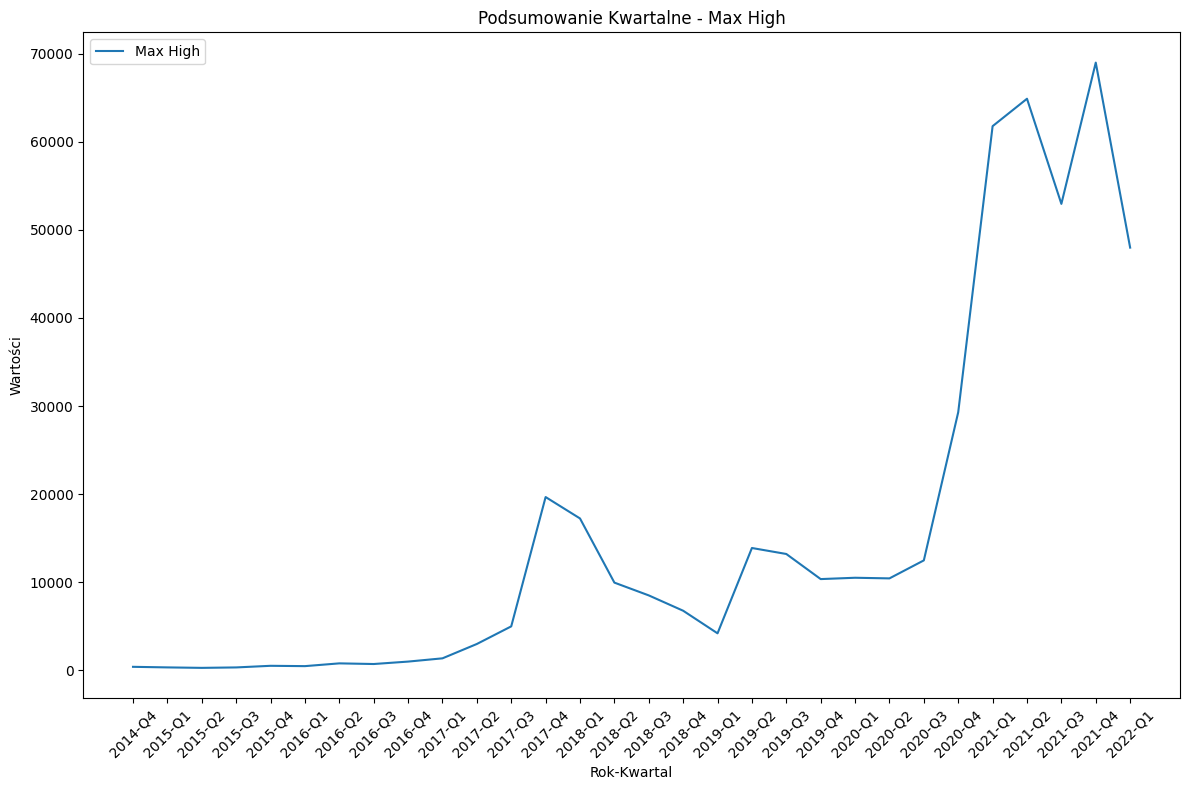

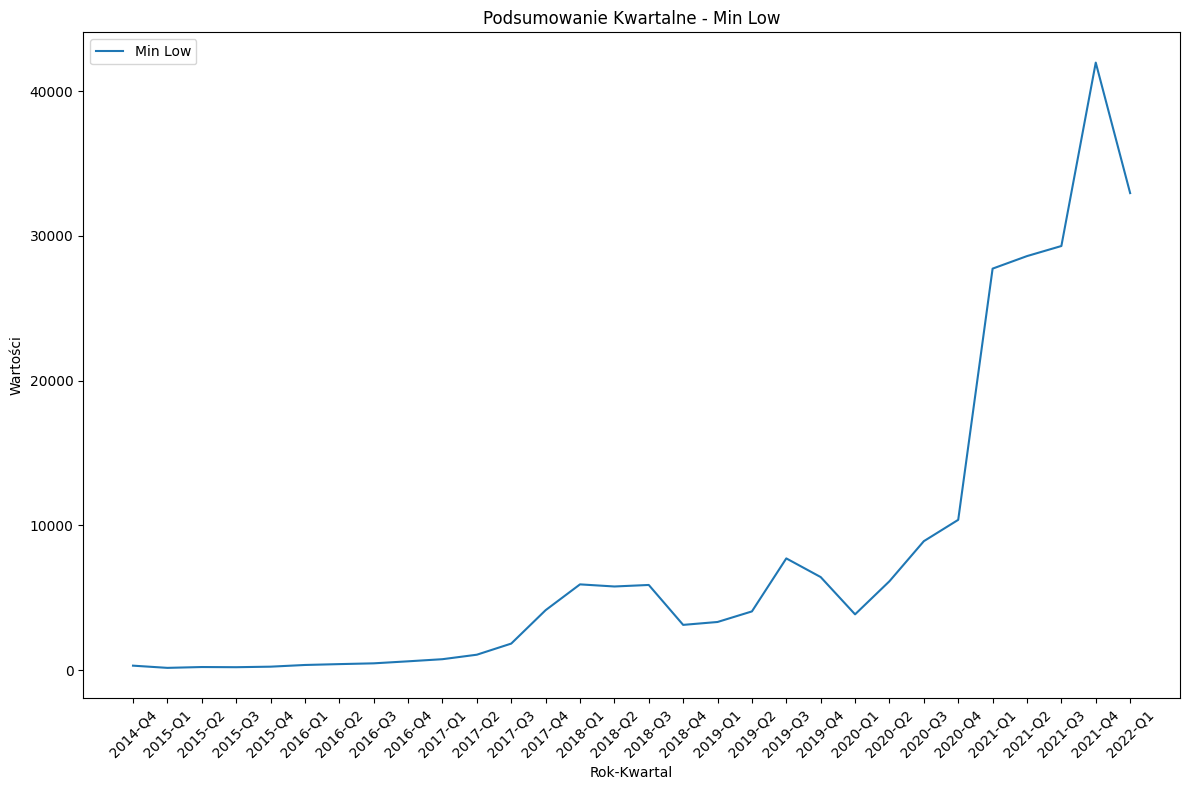

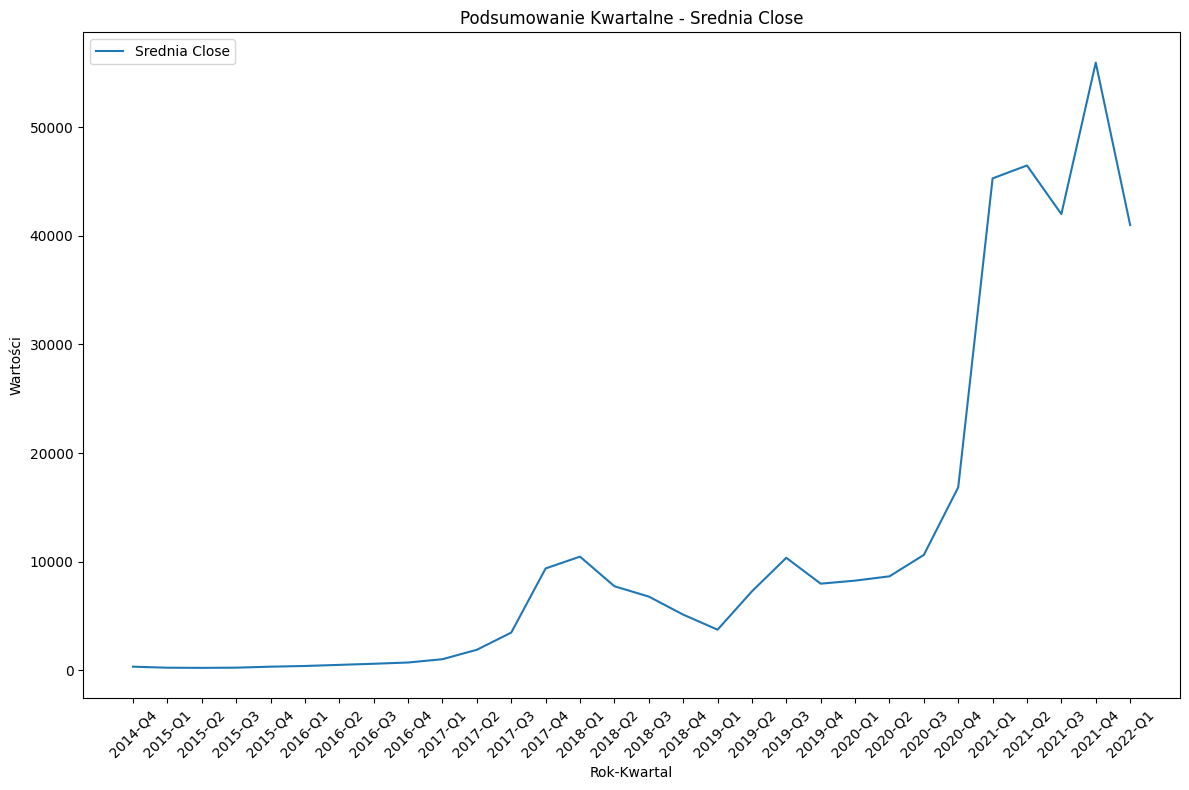

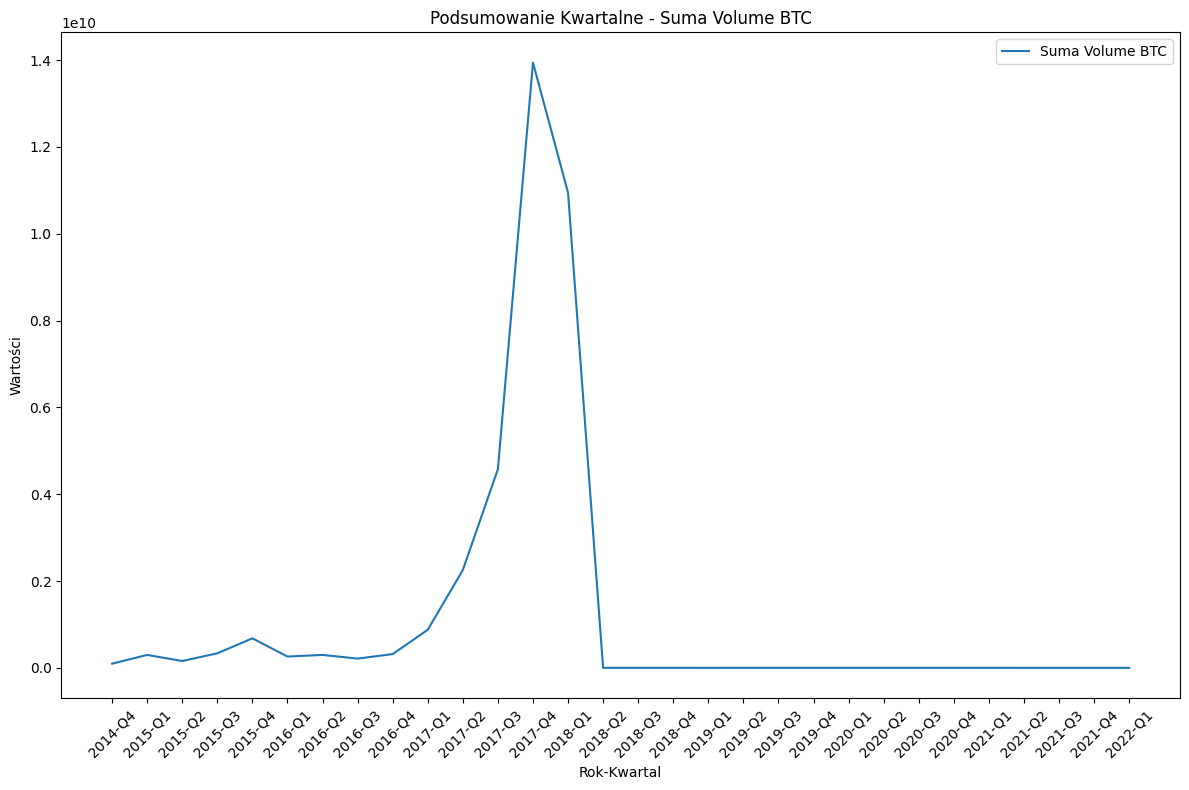

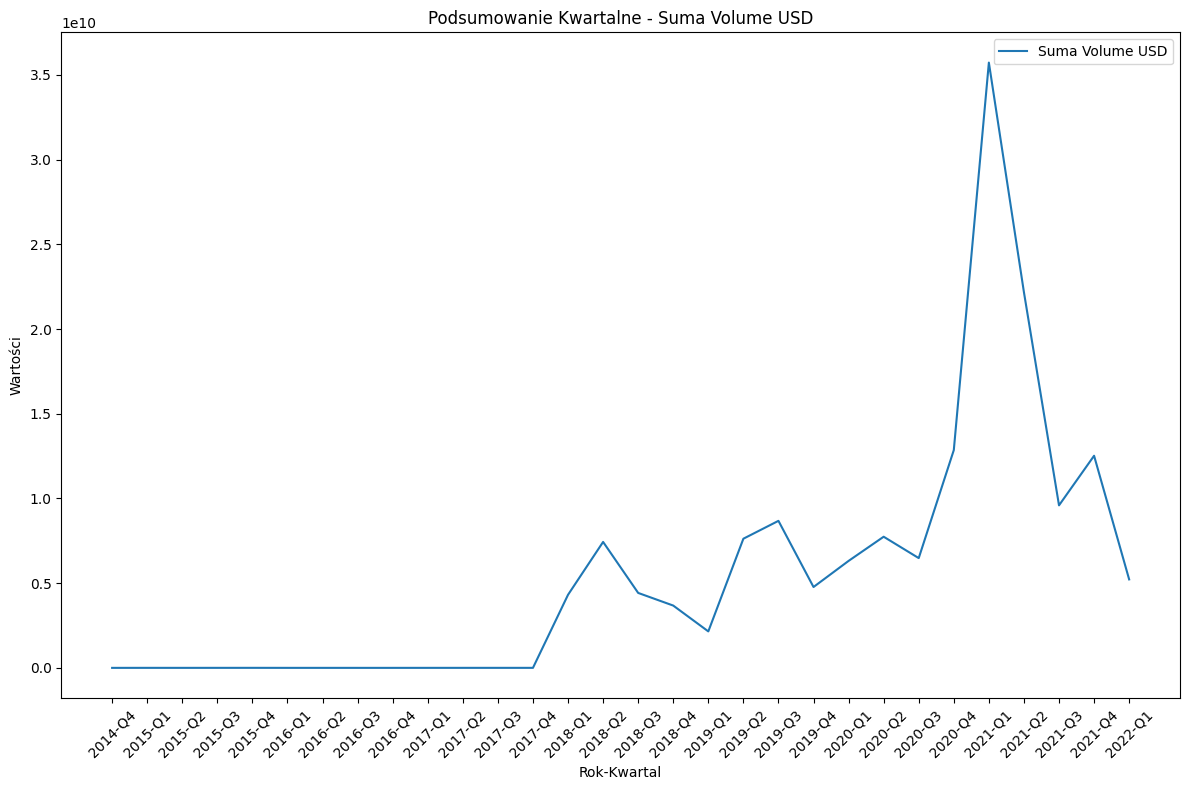

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Utworzenie kursora
cursor = cnn.cursor()

try:
    # Pobieranie danych z tabeli podsumowanie_miesieczne
    cursor.execute("SELECT rok, miesiac, srednia_open, max_high, min_low, srednia_close, suma_volume_btc, suma_volume_usd FROM podsumowanie_miesieczne ORDER BY rok, miesiac")
    result = cursor.fetchall()

    # Przygotowanie danych do wykresów
    rok_miesiac = [f"{row[0]}-{row[1]}" for row in result]
    variables = {
        'Srednia Open': [row[2] for row in result],
        'Max High': [row[3] for row in result],
        'Min Low': [row[4] for row in result],
        'Srednia Close': [row[5] for row in result],
        'Suma Volume BTC': [row[6] for row in result],
        'Suma Volume USD': [row[7] for row in result]
    }

    # Tworzenie osobnych wykresów dla każdej zmiennej
    for variable_name, variable_data in variables.items():
        fig, ax = plt.subplots(figsize=(12, 8))
        index = np.arange(len(rok_miesiac))

        ax.plot(index, variable_data, label=variable_name)

        ax.set_xlabel('Rok-Miesiąc')
        ax.set_ylabel('Wartości')
        ax.set_title(f'Podsumowanie Miesięczne - {variable_name}')
        ax.set_xticks(index)
        ax.set_xticklabels(rok_miesiac, rotation=45)
        ax.legend()

        fig.tight_layout()
        plt.show()

    # Pobieranie danych z tabeli podsumowanie_roczne
    cursor.execute("SELECT rok, srednia_open, max_high, min_low, srednia_close, suma_volume_btc, suma_volume_usd FROM podsumowanie_roczne ORDER BY rok")
    result = cursor.fetchall()

    # Przygotowanie danych do wykresów
    rok = [row[0] for row in result]
    variables = {
        'Srednia Open': [row[1] for row in result],
        'Max High': [row[2] for row in result],
        'Min Low': [row[3] for row in result],
        'Srednia Close': [row[4] for row in result],
        'Suma Volume BTC': [row[5] for row in result],
        'Suma Volume USD': [row[6] for row in result]
    }

    # Tworzenie osobnych wykresów dla każdej zmiennej
    for variable_name, variable_data in variables.items():
        fig, ax = plt.subplots(figsize=(12, 8))
        index = np.arange(len(rok))

        ax.plot(index, variable_data, label=variable_name)

        ax.set_xlabel('Rok')
        ax.set_ylabel('Wartości')
        ax.set_title(f'Podsumowanie Roczne - {variable_name}')
        ax.set_xticks(index)
        ax.set_xticklabels(rok, rotation=45)
        ax.legend()

        fig.tight_layout()
        plt.show()

    # Pobieranie danych z tabeli podsumowanie_kwartalne
    cursor.execute("SELECT rok, kwartal, srednia_open, max_high, min_low, srednia_close, suma_volume_btc, suma_volume_usd FROM podsumowanie_kwartalne ORDER BY rok, kwartal")
    result = cursor.fetchall()

    # Przygotowanie danych do wykresów
    rok_kwartal = [f"{row[0]}-Q{row[1]}" for row in result]
    variables = {
        'Srednia Open': [row[2] for row in result],
        'Max High': [row[3] for row in result],
        'Min Low': [row[4] for row in result],
        'Srednia Close': [row[5] for row in result],
        'Suma Volume BTC': [row[6] for row in result],
        'Suma Volume USD': [row[7] for row in result]
    }

    # Tworzenie osobnych wykresów dla każdej zmiennej
    for variable_name, variable_data in variables.items():
        fig, ax = plt.subplots(figsize=(12, 8))
        index = np.arange(len(rok_kwartal))

        ax.plot(index, variable_data, label=variable_name)

        ax.set_xlabel('Rok-Kwartal')
        ax.set_ylabel('Wartości')
        ax.set_title(f'Podsumowanie Kwartalne - {variable_name}')
        ax.set_xticks(index)
        ax.set_xticklabels(rok_kwartal, rotation=45)
        ax.legend()

        fig.tight_layout()
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Zamknięcie kursora
    cursor.close()